In [1]:
# imports 

#importing libraries

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import pandas as pd

# Load the dataset from a CSV file
df = pd.read_csv('C:/Users/HP/Downloads/boston_house_prices.csv')

# Separate the features and target variable
X = df.drop("MEDV", axis=1)  # Feature Matrix
y = df["MEDV"]               # Target Variable

# Display the first few rows of the DataFrame
df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


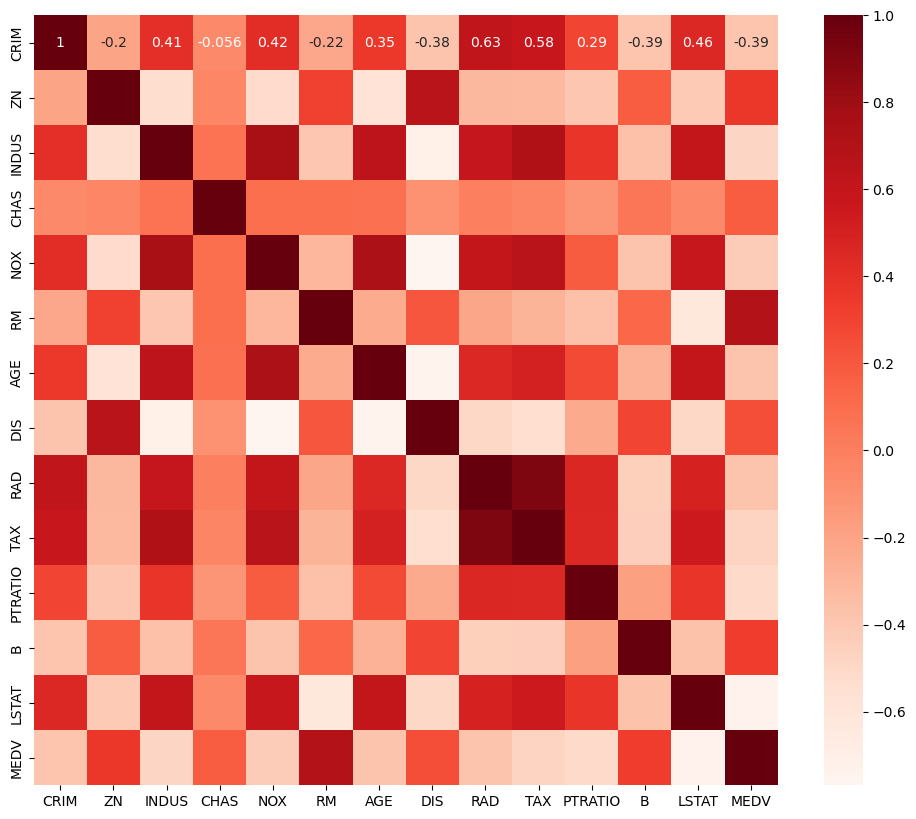

In [11]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor= df.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()


In [15]:
#Correlation with output variable
cor_target = abs(cor["MEDV"])
cor_target

CRIM       0.388305
ZN         0.360445
INDUS      0.483725
CHAS       0.175260
NOX        0.427321
RM         0.695360
AGE        0.376955
DIS        0.249929
RAD        0.381626
TAX        0.468536
PTRATIO    0.507787
B          0.333461
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

In [16]:
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

RM         0.695360
PTRATIO    0.507787
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

In [17]:
#check if the independent variables are correlated
#RM and LSTAT are highly correlated with each other (-0.613808). Hence we would keep only one variable and drop the other.
#keep LSTAT since its correlation with MEDV is higher than that of RM.
print(df[["LSTAT","PTRATIO"]].corr())
print(df[["RM","LSTAT"]].corr())

            LSTAT   PTRATIO
LSTAT    1.000000  0.374044
PTRATIO  0.374044  1.000000
             RM     LSTAT
RM     1.000000 -0.613808
LSTAT -0.613808  1.000000


In [21]:
#Wrapper Method:
#Backward Elimination
import statsmodels.api as sm
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues


const      3.283438e-12
CRIM       1.086810e-03
ZN         7.781097e-04
INDUS      7.382881e-01
CHAS       1.925030e-03
NOX        4.245644e-06
RM         1.979441e-18
AGE        9.582293e-01
DIS        6.013491e-13
RAD        5.070529e-06
TAX        1.111637e-03
PTRATIO    1.308835e-12
B          5.728592e-04
LSTAT      7.776912e-23
dtype: float64

In [22]:
#Backward Elimination
cols = list(X.columns)
pmax =1
while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index= cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [26]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# Initialize the Linear Regression model
model = LinearRegression()

# Initializing RFE model with 7 features to select
rfe = RFE(estimator=model, n_features_to_select=7)

# Transforming data using RFE
X_rfe = rfe.fit_transform(X, y)

# Print the support (selected features) and ranking
print(rfe.support_)
print(rfe.ranking_)


[False False False  True  True  True False  True  True False  True False
  True]
[2 4 3 1 1 1 7 1 1 5 1 6 1]


In [31]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming df is your DataFrame containing features and target variable
X = df.drop("MEDV", axis=1)  # Features
y = df["MEDV"]               # Target Variable

# Define a range of number of features to select
nof_list = np.arange(1, 13)

# Initialize variables to store the best score and corresponding number of features
high_score = 0
optimum_nof = 0
score_list = []

# Iterate over different numbers of features
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    model = LinearRegression()
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if score > high_score:
        high_score = score
        optimum_nof = nof_list[n]

print("Optimum number of features: %d" % optimum_nof)
print("Score with %d features: %f" % (optimum_nof, high_score))


Optimum number of features: 10
Score with 10 features: 0.663581


In [32]:
cols = list(X.columns)
model = LinearRegression()
rfe =RFE(estimator=model, n_features_to_select=10)
X_rfe = rfe.fit_transform(X,y)
model.fit(X_rfe,y)
temp = pd.Series(rfe.support_, index= cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)


Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO',
       'LSTAT'],
      dtype='object')


In [34]:
#Embedded Method
reg = LassoCV()
reg.fit(X,y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)


Best alpha using built-in LassoCV: 0.724820
Best score using built-in LassoCV: 0.702444


In [37]:
print("lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0)) + " variables")

lasso picked 10 variables and eliminated the other 3 variables


Text(0.5, 1.0, 'feature importance using Lasso Model')

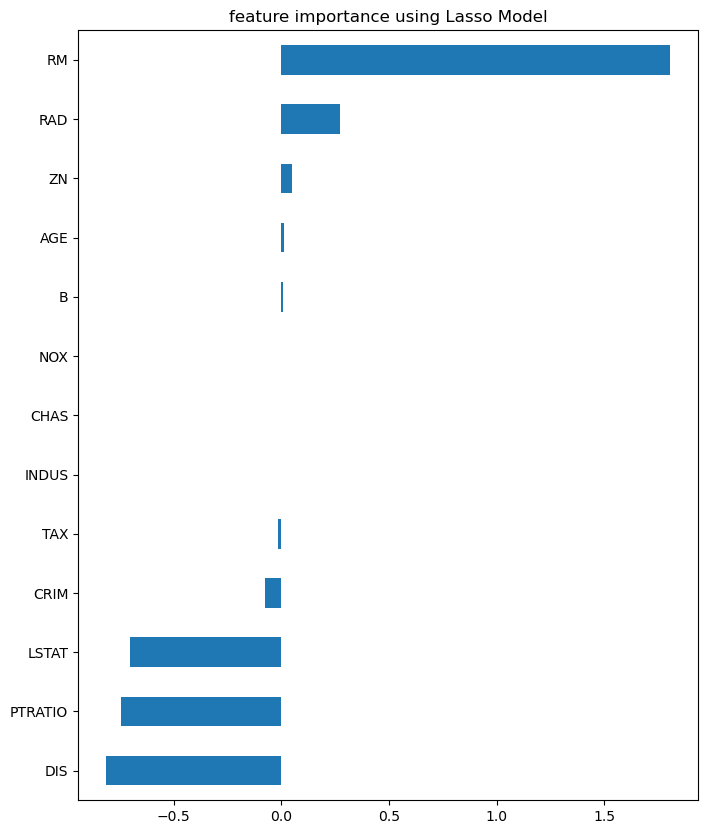

In [38]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0,10.0)
imp_coef.plot(kind="barh")
plt.title("feature importance using Lasso Model")

In [39]:
#chi-square test
import pandas as pd
loan = pd.read_csv('D:/python/JULY_COHORT-master/Lesson16(Feature selection)/loan_data_set.csv')
loan.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [40]:
#Transform the numerical feature into categorical feature
loan['Loan_Amount_Term'] = loan['Loan_Amount_Term'].astype('object')

In [41]:
loan['Credit_History'] = loan['Credit_History'].astype('object')

In [42]:
#Dropping all the null value
loan.dropna(inplace =True)

In [45]:
#Getting all the categorical columns except the target
categorical_columns = loan.select_dtypes(exclude = 'number').drop('Loan_Status', axis = 1).columns
loan.info()
categorical_columns

<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 1 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            480 non-null    object 
 1   Gender             480 non-null    object 
 2   Married            480 non-null    object 
 3   Dependents         480 non-null    object 
 4   Education          480 non-null    object 
 5   Self_Employed      480 non-null    object 
 6   ApplicantIncome    480 non-null    int64  
 7   CoapplicantIncome  480 non-null    float64
 8   LoanAmount         480 non-null    float64
 9   Loan_Amount_Term   480 non-null    object 
 10  Credit_History     480 non-null    object 
 11  Property_Area      480 non-null    object 
 12  Loan_Status        480 non-null    object 
dtypes: float64(2), int64(1), object(10)
memory usage: 52.5+ KB


Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [46]:
pd.crosstab(loan['Gender'], loan['Loan_Status'])

Loan_Status,N,Y
Gender,,
Female,32,54
Male,116,278


In [47]:
# Import the function
from scipy.stats import chi2_contingency
chi_res = chi2_contingency(pd.crosstab(loan['Gender'], loan['Loan_Status']))
print('Chi2 statistics: {}, p-value: {}'.format(chi_res[0],chi_res[1]))

Chi2 statistics: 1.6495637942018448, p-value: 0.1990183114281211


In [51]:
chi2_check = []
for i in categorical_columns:
    if chi2_contingency(pd.crosstab(loan['Loan_Status'],loan[i]))[1]< 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data  = [categorical_columns, chi2_check]).T
res.columns = ['Column','Hypothesis']
print(res)
        
        

             Column                      Hypothesis
0           Loan_ID  Fail to Reject Null Hypothesis
1            Gender  Fail to Reject Null Hypothesis
2           Married          Reject Null Hypothesis
3        Dependents  Fail to Reject Null Hypothesis
4         Education  Fail to Reject Null Hypothesis
5     Self_Employed  Fail to Reject Null Hypothesis
6  Loan_Amount_Term          Reject Null Hypothesis
7    Credit_History          Reject Null Hypothesis
8     Property_Area          Reject Null Hypothesis


In [52]:
property_dummies = pd.get_dummies(data = loan[['Property_Area','Loan_Status']], columns = ['Property_Area'])

In [53]:
property_dummies

,Loan_Status,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
1,N,True,False,False
2,Y,False,False,True
3,Y,False,False,True
4,Y,False,False,True
5,Y,False,False,True
...,...,...,...,...
609,Y,True,False,False
610,Y,True,False,False
611,Y,False,False,True
612,Y,False,False,True


In [54]:
property_dummies = pd.get_dummies(data = loan[['Property_Area', 'Loan_Status']], columns = ['Property_Area'])

In [55]:
property_dummies



,Loan_Status,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
1,N,True,False,False
2,Y,False,False,True
3,Y,False,False,True
4,Y,False,False,True
5,Y,False,False,True
...,...,...,...,...
609,Y,True,False,False
610,Y,True,False,False
611,Y,False,False,True
612,Y,False,False,True


In [56]:
#Example
pd.crosstab(property_dummies['Loan_Status'], property_dummies['Property_Area_Rural'])

Property_Area_Rural,False,True
Loan_Status,,
N,94,54
Y,247,85


In [57]:
check = {}
for i in res[res['Hypothesis'] == 'Reject Null Hypothesis']['Column']:
    dummies = pd.get_dummies(loan[i])
    bon_p_value = 0.05/loan[i].nunique()
    for series in dummies:
        if chi2_contingency(pd.crosstab(loan['Loan_Status'], dummies[series]))[1] < bon_p_value:
            check['{}-{}'.format(i, series)] = 'Reject Null Hypothesis'
        else:
            check['{}-{}'.format(i, series)] = 'Fail to Reject Null Hypothesis'
res_chi_ph = pd.DataFrame(data = [check.keys(), check.values()]).T
res_chi_ph.columns = ['Pair', 'Hypothesis']
res_chi_ph

,Pair,Hypothesis
0,Married-No,Reject Null Hypothesis
1,Married-Yes,Reject Null Hypothesis
2,Loan_Amount_Term-36.0,Fail to Reject Null Hypothesis
3,Loan_Amount_Term-60.0,Fail to Reject Null Hypothesis
4,Loan_Amount_Term-84.0,Fail to Reject Null Hypothesis
5,Loan_Amount_Term-120.0,Fail to Reject Null Hypothesis
6,Loan_Amount_Term-180.0,Fail to Reject Null Hypothesis
7,Loan_Amount_Term-240.0,Fail to Reject Null Hypothesis
8,Loan_Amount_Term-300.0,Fail to Reject Null Hypothesis
9,Loan_Amount_Term-360.0,Fail to Reject Null Hypothesis
